- https://www.youtube.com/watch?v=_yFfc5YB5Xc
- https://github.com/Coding-Crashkurse/LangGraph-Tutorial/blob/main/lcel_vs_langgraph.ipynb

# LangGraph vs. LangChain LCEL - LCEL (LangChain Expression Language)를 대체할 수 있을까?

### LangGraph와 LCEL 소개
- LangGraph와 LangChain Expression Language(LCEL)를 비교하고, LCEL을 대체할 수 있는지 논의합니다.
- LCEL의 파이프 문법에 어려움을 겪는 사용자가 많다는 점을 고려하여, LangGraph가 더 나은 대안이 될 수 있는지 살펴봅니다.

### 파이프라인 구성 비교
- 데이터 임베딩, 벡터 저장소에서의 쿼리, 결과를 LLM(언어 모델)에 전달하여 최종 응답을 얻는 기본 파이프라인을 LCEL과 LangGraph로 각각 구현하는 과정을 시연합니다.
- 코드 예제를 통해 두 접근 방식의 차이점을 명확히 합니다.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain.schema import Document
from langchain_openai import AzureOpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import os

# 임베딩 객체 생성 함수
def Get_Embedding():
    os.environ["AZURE_OPENAI_API_KEY"] = "5acedf2738034ef4be0cd6f075a8e4a3"
    os.environ["AZURE_OPENAI_ENDPOINT"] = "https://aoaibhkim2.openai.azure.com/"
    embedding_function = AzureOpenAIEmbeddings(
            azure_deployment="txt-embed-ada-002-au",
            openai_api_version="2024-03-01-preview",
        )
    return embedding_function

# LLM 객체 생성
def Get_LLM():
  os.environ["AZURE_OPENAI_API_KEY"] = '352a6bee97b5451ab5866993a7ef4ce4'
  os.environ["AZURE_OPENAI_ENDPOINT"] = 'https://aoai-spn-krc.openai.azure.com/'

  model = AzureChatOpenAI(  
    api_version = '2024-02-01',
    azure_deployment = 'gpt-4o-kr-spn',
    temperature = 0.0
  )
  return model

# 샘플 문서 생성
docs = [
    Document(
        page_content="개는 피자를 먹는 것을 좋아합니다.", metadata={"source": "animal.txt"}
    ),
    Document(
        page_content="고양이는 생선을 먹는 것을 좋아합니다.", metadata={"source": "animal.txt"}
    ),
]

# chroma 벡터 DB에 저장
db = Chroma.from_documents(docs, Get_Embedding())

# 검색기 생성, 검색결과는 상위 2개 반환
retriever = db.as_retriever(search_kwargs={"k": 2})

# 문서 조합 함수
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# 프롬프트 생성 - 다음 맥락을 기반으로만 질문에 답하십시오.
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = Get_LLM()

## LCEL

In [3]:
# LCEL RAG 검색 체인 생성
retriever_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [4]:
# 체인 실행
retriever_chain.invoke("고양이는 어떤 음식을 좋아하나요?")

'고양이는 생선을 먹는 것을 좋아합니다.'

## LangGraph

In [5]:
from typing import TypedDict
from langchain_core.messages import BaseMessage

# LLM 체인 생성
chain_with_prompt = prompt | model | StrOutputParser()

In [6]:
# node 상태 저장 클래스
class AgentState(TypedDict):
    question: str # 사용자 질의
    raw_docs: list[BaseMessage] # RAG 검색 결과
    formatted_docs: list[str] # RAG 검색 결과를 조합한 문서
    generation: str # LLM 답변

In [7]:
# RAG 문서 검색 node 함수
def get_docs(state: AgentState):
    print("get_docs:", state)
    question = state["question"] # 사용자 질의
    docs = retriever.invoke(question) # 벡터 DB 검색    
    state["raw_docs"] = docs # 검색 결과 저장
    return state

# RAG 검색 결과를 조합하는 node 함수
def format_docs(state: AgentState):
    print("formating_docs:", state)
    documents = state["raw_docs"] # 검색 결과
    state["formatted_docs"] = "\n\n".join(doc.page_content for doc in documents) # 검색 문서 조합
    return state

# LLM 질의 node 함수
def generate(state: AgentState):
    print("generate:", state)
    question = state["question"] # 사용자 질의
    formatted_docs = state["formatted_docs"] # 조합된 검색 결과
    result = chain_with_prompt.invoke({"question": question, "context": formatted_docs}) # LLM 체인 호출
    state["generation"] = result # LLM 답변
    return state

In [8]:
from langgraph.graph import StateGraph, END

# 상태 Graph 객체 생성
workflow = StateGraph(AgentState)

# node 생성
workflow.add_node("get_docs_node", get_docs)
workflow.add_node("format_docs_node", format_docs)
workflow.add_node("generate_node", generate)

# edge 연결
workflow.add_edge("get_docs_node", "format_docs_node")
workflow.add_edge("format_docs_node", "generate_node")
workflow.add_edge("generate_node", END)

# 시작 node 설정
workflow.set_entry_point("get_docs_node")

# graph 컴파일
app = workflow.compile()

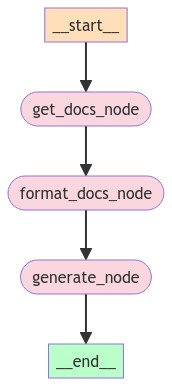

In [9]:
# 시각화
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [10]:
# graph 실행
result = app.invoke({"question": "고양이는 어떤 음식을 좋아하나요?"})
result

get_docs: {'question': '고양이는 어떤 음식을 좋아하나요?', 'raw_docs': None, 'formatted_docs': None, 'generation': None}
formating_docs: {'question': '고양이는 어떤 음식을 좋아하나요?', 'raw_docs': [Document(page_content='고양이는 생선을 먹는 것을 좋아합니다.', metadata={'source': 'animal.txt'}), Document(page_content='개는 피자를 먹는 것을 좋아합니다.', metadata={'source': 'animal.txt'})], 'formatted_docs': None, 'generation': None}
generate: {'question': '고양이는 어떤 음식을 좋아하나요?', 'raw_docs': [Document(page_content='고양이는 생선을 먹는 것을 좋아합니다.', metadata={'source': 'animal.txt'}), Document(page_content='개는 피자를 먹는 것을 좋아합니다.', metadata={'source': 'animal.txt'})], 'formatted_docs': '고양이는 생선을 먹는 것을 좋아합니다.\n\n개는 피자를 먹는 것을 좋아합니다.', 'generation': None}


{'question': '고양이는 어떤 음식을 좋아하나요?',
 'raw_docs': [Document(page_content='고양이는 생선을 먹는 것을 좋아합니다.', metadata={'source': 'animal.txt'}),
  Document(page_content='개는 피자를 먹는 것을 좋아합니다.', metadata={'source': 'animal.txt'})],
 'formatted_docs': '고양이는 생선을 먹는 것을 좋아합니다.\n\n개는 피자를 먹는 것을 좋아합니다.',
 'generation': '고양이는 생선을 먹는 것을 좋아합니다.'}

In [11]:
result["generation"]

'고양이는 생선을 먹는 것을 좋아합니다.'

### LangGraph의 장점
- LangGraph는 데이터를 중앙 에이전트 상태에 저장하여 모든 단계를 모듈화하고 디버깅과 유닛 테스트가 용이합니다.
- 반면 LCEL은 복잡하고 유연성이 떨어지는 파이프라인을 사용합니다.

### 사용 권장 사항
- LangChain 팀은 DAG(Directed Acyclic Graph) 워크플로우에는 LCEL을, 순환이 있는 복잡한 워크플로우에는 LangGraph를 사용할 것을 권장합니다.
- 예시 파이프라인은 DAG 워크플로우이므로 LCEL이 적합하지만, LangGraph의 유연성과 디버깅 용이성 때문에 더 복잡한 작업에는 LangGraph를 추천합니다.